# Statistical analysis describing the use of the BlueBikes system in Boston, Cambridge, Brookline, and Sommerville

## This notebook answer the following questions:

- How many trips occurred through the years?
- What is the average distance rode by users?
- How long do the trips last?
- What is the average age of users?
- What is the average speed of women and men?

In [5]:
import pandas as pd
import numpy as np
import folium
import math
import datetime as dt
import glob
from ipywidgets import interact, widgets
import geopandas as gpd
from shapely.geometry import Point
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
import matplotlib.dates as mdate
import seaborn as sbn
import bikescience.load_trips as tr
import bikescience.distributions as dist
import bikescience.charts as ch
import scipy.stats as st
pd.set_option('precision', 1) #be careful because this also applies to lat long
# global settings for the charts
plt.rcParams['font.family'] = 'FreeSerif'
#plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 22
plt.rcParams['figure.titlesize'] = 26
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['axes.grid.axis'] = 'y'
plt.rcParams['axes.grid'] = True
plt.rcParams['legend.fontsize'] = 18

## Loading all BlueBike trips

In [2]:
trips = tr.load_all_trips('../data/boston/bike-trips')
print(len(trips), 'trips')
trips.head()

8194337 trips


tripduration           starttime            stoptime  start station id  \
0           445 2013-08-31 23:59:00 2013-09-01 00:06:00                 4   
1           438 2013-08-31 23:59:00 2013-09-01 00:06:00                 4   
2           643 2013-08-31 09:21:00 2013-08-31 09:32:00                 4   
3          1142 2013-08-30 18:55:00 2013-08-30 19:14:00                 4   
4          1095 2013-08-30 18:55:00 2013-08-30 19:13:00                 4   

            start station name  start station latitude  \
0  Tremont St at E Berkeley St                    42.3   
1  Tremont St at E Berkeley St                    42.3   
2  Tremont St at E Berkeley St                    42.3   
3  Tremont St at E Berkeley St                    42.3   
4  Tremont St at E Berkeley St                    42.3   

   start station longitude  end station id           end station name  \
0                    -71.1              52  Newbury St at Hereford St   
1                    -71.1              52  Newbury St at Hereford St   
2                    -71.1              52  Newbury St at Hereford St   
3                    -71.1              52  Newbury St at Hereford St   
4                    -71.1              52  Newbury St at Hereford St   

   end station latitude  end station longitude  bikeid    usertype birth year  \
0                  42.3                  -71.1  B00535  Subscriber       1969   
1                  42.3                  -71.1  T01447  Subscriber       1969   
2                  42.3                  -71.1  T01152  Subscriber       1969   
3                  42.3                  -71.1  T01166    Customer       1969   
4                  42.3                  -71.1  T01030  Subscriber       1969   

   gender    per_day  hour  week_day  weekend  holiday  
0     1.0 2013-08-31    23         5     True    False  
1     2.0 2013-08-31    23         5     True    False  
2     1.0 2013-08-31     9         5     True    False  
3     NaN 2013-08-30    18         4    False    False  
4     1.0 2013-08-30    18         4    False    False

### Data cleaning: station id 164 is only for tests. It has no latitude / longitude 

In [3]:
trips = trips[(trips['end station latitude'] != 0) & 
              (trips['end station longitude'] != 0) &
              (trips['start station latitude'] != 0) & 
              (trips['start station longitude'] != 0)]

trips.shape[0]

trips[trips['end station id'] == 164]

Empty DataFrame
Columns: [tripduration, starttime, stoptime, start station id, start station name, start station latitude, start station longitude, end station id, end station name, end station latitude, end station longitude, bikeid, usertype, birth year, gender, per_day, hour, week_day, weekend, holiday]
Index: []

## Age distribution

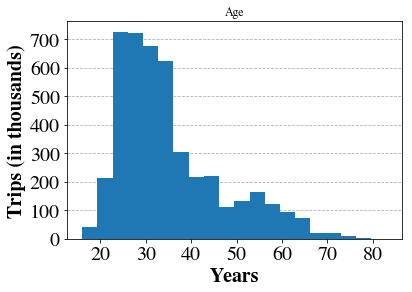

In [4]:
try:
    tage = trips[(trips["birth year"] != '\\N')]
except TypeError:
        pass

tage = tage.dropna()
tage["birth year"] = tage["birth year"].astype(int)

tage = tage[(tage["birth year"] != 1969) & (tage["birth year"] > 1934)]
tage["age"] = 2018 - tage["birth year"]

tage = tage[['age']]

ax_age = plt.axes()
ax_age.set_axisbelow(True)
plt.grid(linestyle='--')
ax_age.xaxis.grid(False)
formatter = tkr.FuncFormatter(ch.numbers_in_thousands)
ax_age.yaxis.set_major_formatter(formatter)
plt.hist(bins=20,x=tage['age'])
plt.title('Age')
plt.xlabel('Years')
plt.ylabel('Trips (in thousands)')
plt.xticks(np.arange(20,81,step=10))
plt.yticks(np.arange(0,700001,step=100000))
fig_age = plt.gcf()

## Gender distribution

In [6]:
pd.crosstab( trips["usertype"], trips["gender"], normalize='index', margins=True)*100

gender       0.0   1.0   2.0
usertype                    
Customer    62.4  28.3   9.4
Subscriber   5.8  70.5  23.7
All         15.3  63.4  21.3

##   Trip duration distribution

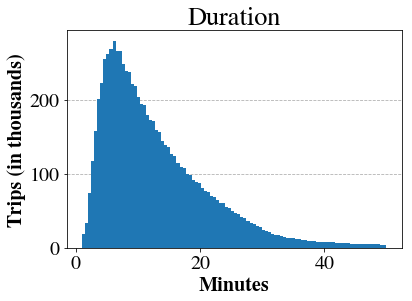

In [7]:
duration = trips[trips['tripduration'] < 3000]

duration = duration[['tripduration']]

ax_duration = plt.axes()
ax_duration.set_axisbelow(True)
plt.grid(linestyle='--')
ax_duration.xaxis.grid(False)
formatter = tkr.FuncFormatter(ch.numbers_in_thousands)
ax_duration.yaxis.set_major_formatter(formatter)
plt.hist(bins=100,x=duration['tripduration']/60)
plt.title('Duration')
plt.xlabel('Minutes')
plt.ylabel('Trips (in thousands)')
fig_duration = plt.gcf()

In [8]:
pd.set_option('display.float_format', lambda x: '%.1f' % x)
(trips['tripduration']/60).describe()

count   8194281.0
mean         20.1
std         393.4
min           1.0
25%           6.7
50%          11.1
75%          18.3
max      498434.7
Name: tripduration, dtype: float64

### Discovering the best distribution fitness (it takes hours to run)

In [ ]:
duration_dist, duration_params = dist.best_fit_distribution(duration['tripduration']/60, bins=100)
duration_dist, duration_params

Trying 0/89


In [14]:
duration_pdf = dist.make_pdf(duration_dist, duration_params)
plt.figure(figsize=(12,8))
ax = duration_pdf.plot(lw=3, label='Duration PDF', legend=True)
(duration['tripduration']/60).hist(bins=100, ax=ax)
plt.show()

NameError: name 'duration_dist' is not defined

### Checking fitness of specific distributions

In [22]:
distrib = st.lognorm
#distrib = st.norm
#distrib = st.chi
#distrib = st.t
#distrib = st.johnsonsb
duration_sse, duration_params = dist.fit_distribution(distrib,duration['tripduration']/60, bins=100)
print('Duration', duration_sse, duration_params)

Duration 0.0007248751907130444 (0.6325142602038316, -0.47275700556519884, 11.13047562204813)


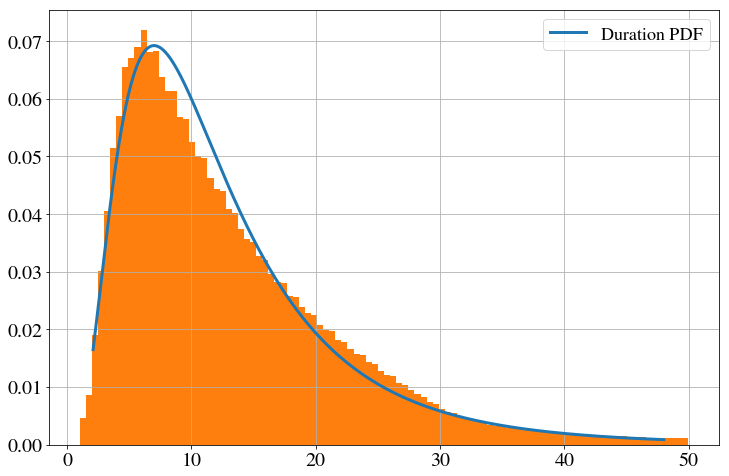

<Figure size 432x288 with 0 Axes>

In [23]:
duration_pdf = dist.make_pdf(distrib, duration_params)
plt.figure(figsize=(12,8))
ax = duration_pdf.plot(lw=3, label='Duration PDF', legend=True)
(duration['tripduration']/60).hist(bins=100, ax=ax, density=True)
plt.show()
plt.savefig('charts/distribution_duration.png', format='png', dpi=200)

### Trips by user type

In [9]:
trips['usertype'].value_counts()

Subscriber    6423945
Customer      1770336
Name: usertype, dtype: int64

In [10]:
subscribers = [trips['usertype'] == 'Subscriber']
customers = trips[trips['usertype'] == 'Customer']
print("{0:.2%}".format(len(subscribers) / len(trips)),'subscribers')
print("{0:.2%}".format(len(customers) / len(trips)),'customers')

0.00% subscribers
21.60% customers


## Duration of trips according to where it starts and gender

In [11]:
gender_duration = trips[trips['gender'] != 0]
gender_duration = pd.pivot_table(gender_duration, values='tripduration', index=['start station id'], 
                                 columns=['gender'],margins=True)
gender_duration.head(10)

gender              1.0    2.0    All
start station id                     
1                4120.2 1818.0 3515.7
3                 874.0 1037.5  926.5
4                 886.3 1085.1  936.7
5                 793.4  847.3  807.2
6                 827.0 1019.9  876.6
7                 964.7  946.7  961.7
8                1595.7 1171.6 1485.9
9                 908.8  862.6  896.1
10                798.7  950.1  844.7
11                835.3 1027.0  895.3

# Distance

Using the GraphHoper algorithm

In [12]:
stations_distances = pd.read_csv('../data/boston/bike-stations/stations_distances.csv', index_col=['id_x', 'id_y'])
trips = trips.merge(stations_distances, left_on=['start station id', 'end station id'], right_index=True)

#calculating speed
trips['speed'] = trips['distance']/trips['tripduration']*3600

trips.head()

tripduration           starttime            stoptime  start station id  \
0           445 2013-08-31 23:59:00 2013-09-01 00:06:00                 4   
1           438 2013-08-31 23:59:00 2013-09-01 00:06:00                 4   
2           643 2013-08-31 09:21:00 2013-08-31 09:32:00                 4   
3          1142 2013-08-30 18:55:00 2013-08-30 19:14:00                 4   
4          1095 2013-08-30 18:55:00 2013-08-30 19:13:00                 4   

            start station name  start station latitude  \
0  Tremont St at E Berkeley St                    42.3   
1  Tremont St at E Berkeley St                    42.3   
2  Tremont St at E Berkeley St                    42.3   
3  Tremont St at E Berkeley St                    42.3   
4  Tremont St at E Berkeley St                    42.3   

   start station longitude  end station id           end station name  \
0                    -71.1              52  Newbury St at Hereford St   
1                    -71.1              52  Newbury St at Hereford St   
2                    -71.1              52  Newbury St at Hereford St   
3                    -71.1              52  Newbury St at Hereford St   
4                    -71.1              52  Newbury St at Hereford St   

   end station latitude  ...      usertype birth year gender    per_day  hour  \
0                  42.3  ...    Subscriber       1969    1.0 2013-08-31    23   
1                  42.3  ...    Subscriber       1969    2.0 2013-08-31    23   
2                  42.3  ...    Subscriber       1969    1.0 2013-08-31     9   
3                  42.3  ...      Customer       1969    nan 2013-08-30    18   
4                  42.3  ...    Subscriber       1969    1.0 2013-08-30    18   

  week_day  weekend  holiday  distance  speed  
0        5     True    False       1.9   15.7  
1        5     True    False       1.9   16.0  
2        5     True    False       1.9   10.9  
3        4    False    False       1.9    6.1  
4        4    False    False       1.9    6.4  

[5 rows x 22 columns]

### Trip distance profile (ignoring round-trips)

Text(0,0.5,'Trips (in thousands)')

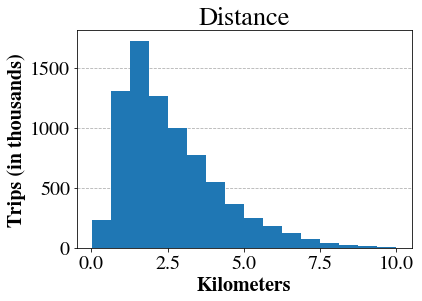

In [13]:
distance = trips[(trips.distance<10) & (trips.distance>0)]

distance = distance[['distance']]

ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
formatter = tkr.FuncFormatter(ch.numbers_in_thousands)
ax_distance.yaxis.set_major_formatter(formatter)
plt.hist(bins=16,x=distance['distance'])
plt.title('Distance')
plt.xlabel('Kilometers')
plt.ylabel('Trips (in thousands)')
#fig_distance = plt.gcf()

In [14]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
distance['distance'].describe()

count   7905042.000
mean          2.611
std           1.586
min           0.022
25%           1.411
50%           2.236
75%           3.434
max           9.999
Name: distance, dtype: float64

## Both genders ride ~2Km per trip on average


In [15]:
gender = trips[trips['gender'] != 0].copy()
gender = gender[gender.distance < 50]
gender.reset_index(inplace=True)
pd.pivot_table(gender, values='distance', index=['start station id'], 
               columns=['gender'],margins=True ).head(10)

gender             1.0   2.0   All
start station id                  
1                3.825 3.772 3.811
3                2.630 2.856 2.702
4                2.678 2.737 2.693
5                2.417 2.462 2.428
6                2.646 2.772 2.679
7                2.597 2.540 2.587
8                4.022 3.912 3.994
9                2.576 2.676 2.604
10               2.612 2.736 2.650
11               2.949 3.110 2.999

In [41]:
gender.memory_usage()

Index                            80
index                      54571560
tripduration               54571560
starttime                  54571560
stoptime                   54571560
start station id           54571560
start station name         54571560
start station latitude     54571560
start station longitude    54571560
end station id             54571560
end station name           54571560
end station latitude       54571560
end station longitude      54571560
bikeid                     54571560
usertype                   54571560
birth year                 54571560
gender                     54571560
per_day                    54571560
hour                       54571560
week_day                   54571560
weekend                     6821445
distance                   54571560
dtype: int64

## But Women are a little less in a hurry :-)


In [16]:
gender = gender[['gender','distance','tripduration','speed']]
gender.speed.describe()

count   7011703.000
mean         13.578
std           5.489
min           0.000
25%          10.949
50%          13.795
75%          16.508
max         515.063
Name: speed, dtype: float64

Text(0,0.5,'Trips (density)')

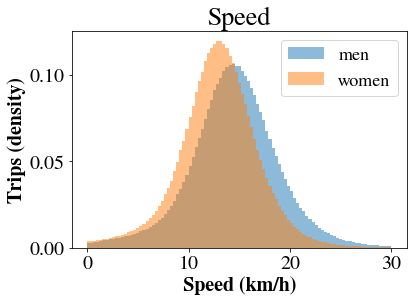

In [17]:
women_speed = gender[(gender.gender == 2) & (gender.speed> 0) & (gender.speed < 30)].speed
men_speed   = gender[(gender.gender == 1) & (gender.speed> 0) & (gender.speed < 30)].speed

bins = np.linspace(0, 30, 100)
ax_gender = plt.axes()
ax_gender.xaxis.grid(False)
ax_gender.yaxis.grid(False)
plt.hist(men_speed, bins, alpha=0.5, label='men', density=True)
plt.hist(women_speed, bins, alpha=0.5, label='women', density=True)
plt.legend(loc='upper right')
plt.title('Speed')
plt.xlabel('Speed (km/h)')
plt.ylabel('Trips (density)')

### Discovering the best distribution fitness (it takes hours to run)

In [ ]:
women_dist, women_params = dist.best_fit_distribution(gender[gender.gender == 2].speed, bins=100)
print('Women:', women_dist, women_params)
men_dist, men_params = dist.best_fit_distribution(gender[gender.gender ==1].speed, bins=100)
print('Men:', men_dist, men_params)
women_pdf = dist.make_pdf(women_dist, women_params)
men_pdf = dist.make_pdf(men_dist, men_params)
plt.figure(figsize=(12, 8))
ax = women_pdf.plot(lw=3, label='Women PDF', legend=True)
men_pdf.plot(lw=3, label='Men PDF', legend=True, ax=ax)
plt.hist(men_speed, bins, alpha=0.5, label='men speed', density=True, ax=ax)
plt.hist(women_speed, bins, alpha=0.5, label='women speed', density=True, ax=ax)
plt.show()

Trying 0/89
Trying 1/89


### Checking fitness of individual distributions

Women: 0.00011006432950278486 (3.700288495233704, 12.889280577252276, 3.2071696940703784)
Men: 7.440940384235909e-05 (3.754391323419028, 14.423150399940756, 3.619528864908372)


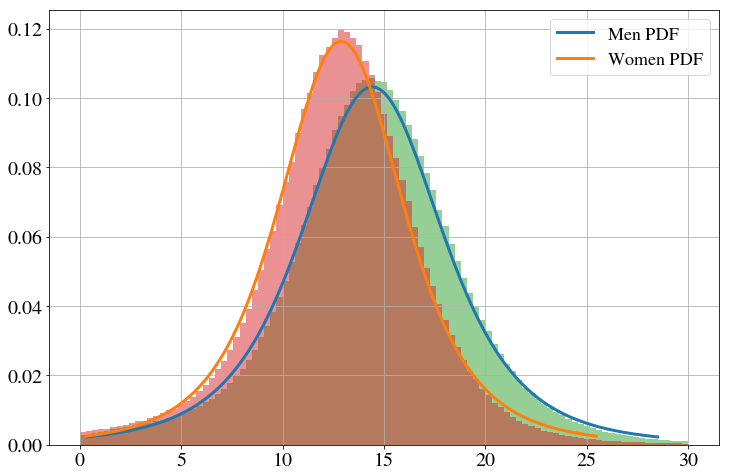

In [47]:
#distrib=st.norm
#distrib=st.chi2
#distrib=st.lognorm
distrib=st.t

women_sse, women_params = dist.fit_distribution(distrib,gender[gender.gender == 2].speed, bins=100)
print('Women:', women_sse, women_params)
men_sse, men_params = dist.fit_distribution(distrib,gender[gender.gender ==1].speed, bins=100)
print('Men:', men_sse, men_params)
women_pdf = dist.make_pdf(distrib, women_params)
men_pdf = dist.make_pdf(distrib, men_params)
plt.figure(figsize=(12, 8))
ax = men_pdf.plot(lw=3, label='Men PDF', legend=True)
women_pdf.plot(lw=3, label='Women PDF', legend=True, ax=ax)
plt.hist(men_speed, bins, alpha=0.5, label='men speed', density=True)
plt.hist(women_speed, bins, alpha=0.5, label='women speed', density=True)
#plt.show()
plt.savefig('charts/distribution_speed_men_women.png', format='png', dpi=200)

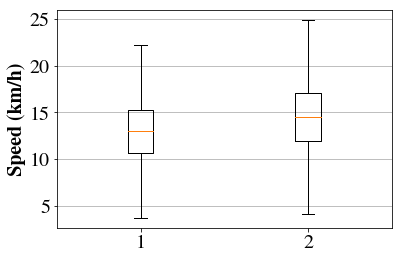

In [48]:
#boxplots
plt.boxplot([women_speed,men_speed],showfliers=False)
pos=[1,2]
plt.ylabel('Speed (km/h)')
plt.savefig('charts/speed_men_women_boxplot.png', format='png', dpi=200)

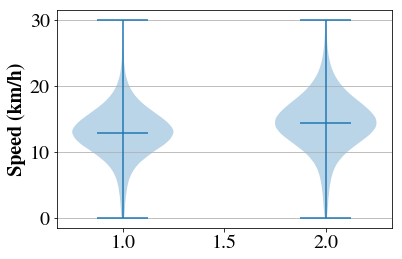

In [49]:
#violinplots
pos=[1,2]
plt.violinplot([women_speed.values,men_speed.values],pos,showmeans=True,showmedians=False)
plt.ylabel('Speed (km/h)')
plt.savefig('charts/speed_men_women_violin.png', format='png', dpi=200)

## Figure 1: Age, Duration, Distance, and Speed

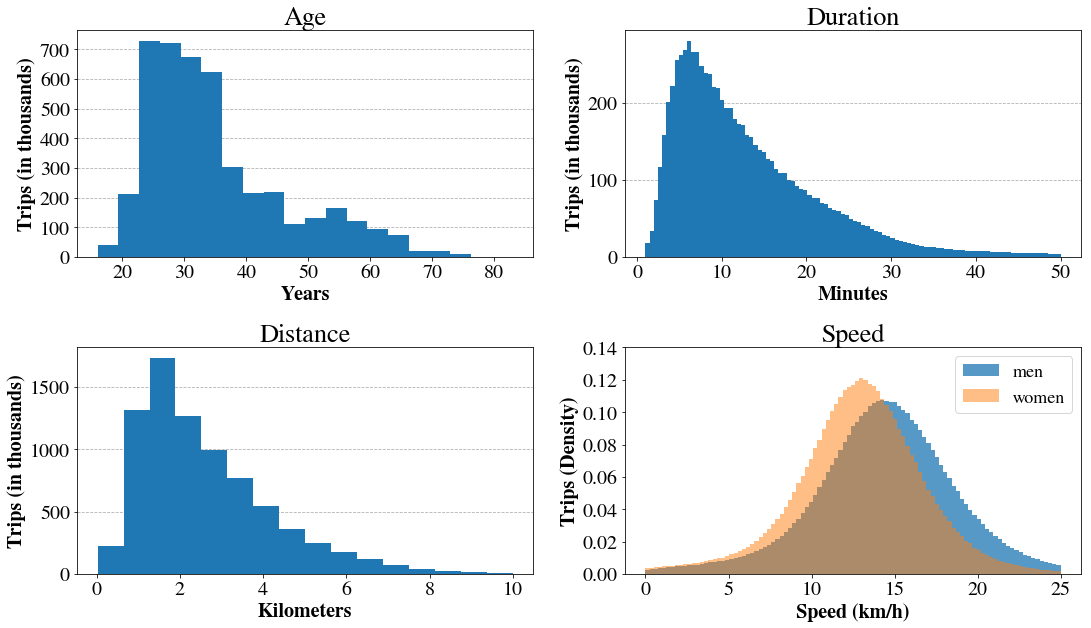

In [18]:
fig, axes = plt.subplots(2,2,figsize=(18,10))
plt.subplots_adjust(hspace=0.4)
#age
axes[0,0].set_axisbelow(True)
axes[0,0].grid(linestyle='--')
axes[0,0].xaxis.grid(False)
axes[0,0].set_title('Age')
axes[0,0].set_xlabel('Years')
axes[0,0].set_ylabel('Trips (in thousands)')
formatter = tkr.FuncFormatter(ch.numbers_in_thousands)
axes[0,0].yaxis.set_major_formatter(formatter)
axes[0,0].set_xticks(np.arange(20,81,step=10))
axes[0,0].set_yticks(np.arange(0,700001,step=100000))
axes[0,0].hist(bins=20,x=tage['age'])

#duration
axes[0,1].set_axisbelow(True)
axes[0,1].grid(linestyle='--')
axes[0,1].xaxis.grid(False)
axes[0,1].set_title('Duration')
axes[0,1].set_xlabel('Minutes')
axes[0,1].set_ylabel('Trips (in thousands)')
formatter = tkr.FuncFormatter(ch.numbers_in_thousands)
axes[0,1].yaxis.set_major_formatter(formatter)
axes[0,1].hist(bins=100,x=duration['tripduration']/60)

#distance
axes[1,0].set_axisbelow(True)
axes[1,0].grid(linestyle='--')
axes[1,0].xaxis.grid(False)
axes[1,0].set_title('Distance')
axes[1,0].set_xlabel('Kilometers')
axes[1,0].set_ylabel('Trips (in thousands)')
formatter = tkr.FuncFormatter(ch.numbers_in_thousands)
axes[1,0].yaxis.set_major_formatter(formatter)
#axes[1,0].set_xticks(np.arange(0,12,step=2))
axes[1,0].hist(bins=16,x=distance['distance'])
#axes[1,0].set_yticks(np.arange(0,500000,step=50000))

# speed
bins = np.linspace(0, 25, 100)
axes[1,1].xaxis.grid(False)
axes[1,1].yaxis.grid(False)
axes[1,1].hist(men_speed, bins, alpha=0.75, label='men', density=True)
axes[1,1].hist(women_speed, bins, alpha=0.5, label='women', density=True)
axes[1,1].legend(loc='upper right')
axes[1,1].set_title('Speed')
axes[1,1].set_xlabel('Speed (km/h)')
axes[1,1].set_ylabel('Trips (Density)')
axes[1,1].set_yticks(np.arange(0,0.15,step=0.02))

plt.savefig('charts/figure1.pdf', format='pdf', dpi=200)

## Figure 2: Trips per month and gender - day usage average, standard deviation, and 12-month rolling from 2011 to 2018

In [19]:
trip_time_series = trips.copy()
trip_time_series['dateindex'] = pd.to_datetime(trip_time_series['starttime'])
trip_time_series = trip_time_series.set_index(pd.DatetimeIndex(trip_time_series['dateindex']))
trip_time_series = trip_time_series[['dateindex','gender']]
trip_time_series.head(3)

dateindex  gender
dateindex                                      
2013-08-31 23:59:00 2013-08-31 23:59:00   1.000
2013-08-31 23:59:00 2013-08-31 23:59:00   2.000
2013-08-31 09:21:00 2013-08-31 09:21:00   1.000

### Getting the daily average per month

In [20]:
trips_day_average = trip_time_series['dateindex'].groupby(pd.Grouper(freq='D')).count()
trips_per_day = trips_day_average.groupby(pd.Grouper(freq='M')).agg({'mean':'mean','std':'std'})#.plot()

/home/higor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  


In [21]:
#trips_per_day['mean']
trips_day_average.head()

dateindex
2011-07-28     399
2011-07-29     530
2011-07-30     798
2011-07-31    1002
2011-08-01     775
Freq: D, Name: dateindex, dtype: int64

### Percentage of women trips

In [22]:
#women bike usage percentage
women_trips = trip_time_series[(trip_time_series.gender == 2)]
men_trips = trip_time_series[(trip_time_series.gender == 1)]

women_trips_day_count = women_trips['dateindex'].groupby(pd.Grouper(freq='D')).count()
men_trips_day_count = men_trips['dateindex'].groupby(pd.Grouper(freq='D')).count()

women_trips_per_month = women_trips_day_count.groupby(pd.Grouper(freq='M')).agg({'sum':'sum'})
men_trips_per_month = men_trips_day_count.groupby(pd.Grouper(freq='M')).agg({'sum':'sum'})

women_percentage_per_month = men_trips_per_month.copy()
women_percentage_per_month['women'] = women_trips_per_month['sum']
women_percentage_per_month.rename(columns={'sum':'men'},inplace=True)
women_percentage_per_month['percentage'] = women_percentage_per_month['women']/(women_percentage_per_month['women']+women_percentage_per_month['men'])*100

/home/higor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  
/home/higor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


### Calculating 12-month rolling average

In [23]:
trips_12_month_rolling = trips_per_day.sort_index().rolling(12).mean().dropna()
trips_12_month_rolling.head(5)

mean     std
dateindex                  
2012-06-30  893.689 323.975
2012-07-31 1025.222 329.894
2012-08-31 1155.197 327.295
2012-09-30 1273.392 351.858
2012-10-31 1381.736 377.383

### Creating the chart

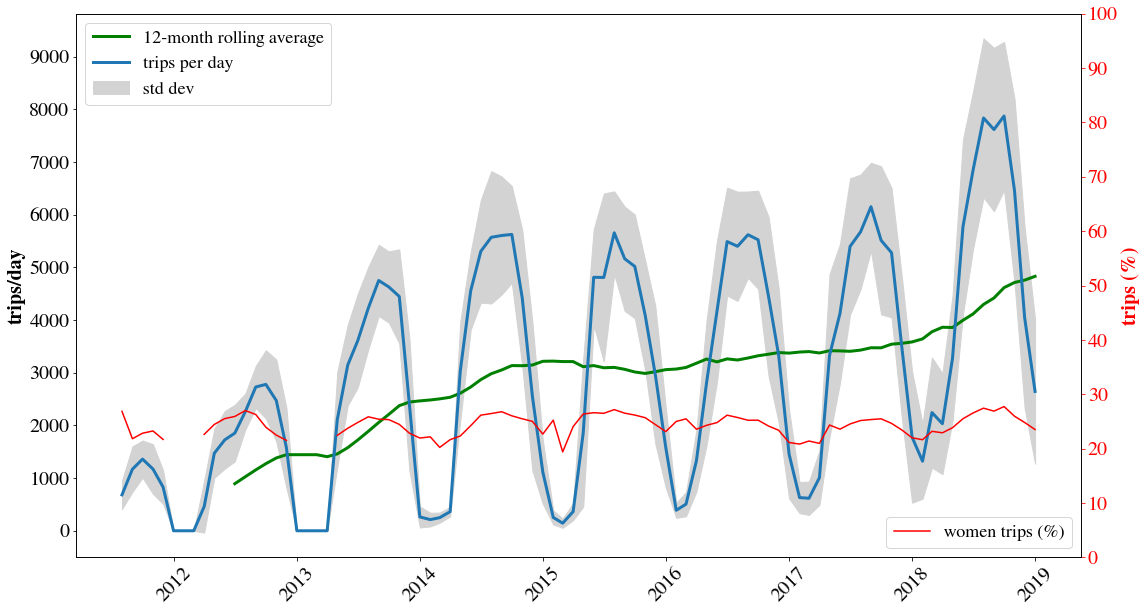

In [26]:
#dateFmt = mdate.DateFormatter('%b/%y')
dateFmt = mdate.DateFormatter('%Y')
ax_day_avg_gender = plt.axes()
ax_day_avg_gender.set_axisbelow(True)
ax_day_avg_gender.xaxis.grid(False)
ax_day_avg_gender.yaxis.grid(False)
#formatter = tkr.FuncFormatter(ch.numbers_in_thousands)
ax_day_avg_gender.plot(trips_12_month_rolling['mean'],label='12-month rolling average',linewidth=3,color='green')
#axDayAvg.yaxis.set_major_formatter(formatter)
ax_day_avg_gender.plot(trips_per_day['mean'],label='trips per day',linewidth=3)
#ax_day_avg_gender.set_xticks(trips_per_day.index)
ax_day_avg_gender.figure.set_size_inches(18,10)
ax_day_avg_gender.xaxis.set_major_formatter(dateFmt)
#ax_day_avg_gender.xaxis.set_major_locator(mdate.YearLocator())#.tick_values(2011,2018))
#ax_day_avg_gender.xaxis.set_minor_locator(mdate.MonthLocator())
#ax_day_avg_gender.set_xlim(trips_per_day.index.date.min().year,trips_per_day.index.date.max().year)
#ax_day_avg_gender.tick_params('y',colors='blue')
#plt.title('Average of daily trips per month and gender')
plt.ylabel('trips/day')
plt.xticks(rotation=45)
plt.yticks(np.arange(0,10001,step=1000))
plt.fill_between(trips_per_day.index,trips_per_day['mean']-trips_per_day['std'],
                 trips_per_day['mean']+trips_per_day['std'],color='lightgray',label='std dev')
plt.legend(loc='center left')
ax_perc_women = ax_day_avg_gender.twinx()
ax_perc_women.plot(women_percentage_per_month.index,women_percentage_per_month['percentage'],label='women trips (%)',color='red')
ax_perc_women.set_ylabel('trips (%)', color='red')
ax_perc_women.yaxis.grid(False)
ax_perc_women.xaxis.set_major_formatter(dateFmt)
ax_perc_women.set_yticks(np.arange(0,30.1,step=5))
ax_perc_women.legend(loc='upper left')
ax_perc_women.tick_params('y',colors='red')

#ax_year_avg_gender = ax_day_avg_gender.twinx()
#ax_year_avg_gender = ax_day_avg_gender.twiny()
#ax_year_avg_gender.plot(trips_per_year['mean'],label='12-month rolling average',linewidth=3,color='green',marker='*')
#ax_year_avg_gender.legend(loc='lower right')

plt.savefig('charts/Trips-Evolution-2011-2018.pdf', format='pdf', dpi=200)
plt.draw()

## Figure: Trips per month and gender - day usage average, standard deviation, and 12-month rolling from Apr/2013 to 2018

### Getting the daily average per month

In [27]:
trips_per_day_2013 = trips_per_day[((trips_per_day.index.year == 2013) & (trips_per_day.index.month >= 4)) 
                                   | (trips_per_day.index.year > 2013)]
#trips_per_day_2013.head()
len(trips_per_day_2013)

69

### Bike use ratio between men and women

In [29]:
women_percentage_per_month_2013 = women_percentage_per_month[((women_percentage_per_month.index.year == 2013) 
                                                            & (women_percentage_per_month.index.month >= 4)) 
                                                           | (women_percentage_per_month.index.year > 2013)]
#women_percentage_per_month_2013.head()
len(women_percentage_per_month_2013)

69

### Calculating 12-month rolling average

In [30]:
trips_12_month_rolling_2013 = trips_per_day_2013.sort_index().rolling(12).mean().dropna()
trips_12_month_rolling_2013.head(5)

mean     std
dateindex                  
2014-03-31 2533.757 613.202
2014-04-30 2610.474 615.937
2014-05-31 2727.968 613.487
2014-06-30 2868.974 620.650
2014-07-31 2981.116 660.291

### Creating the chart

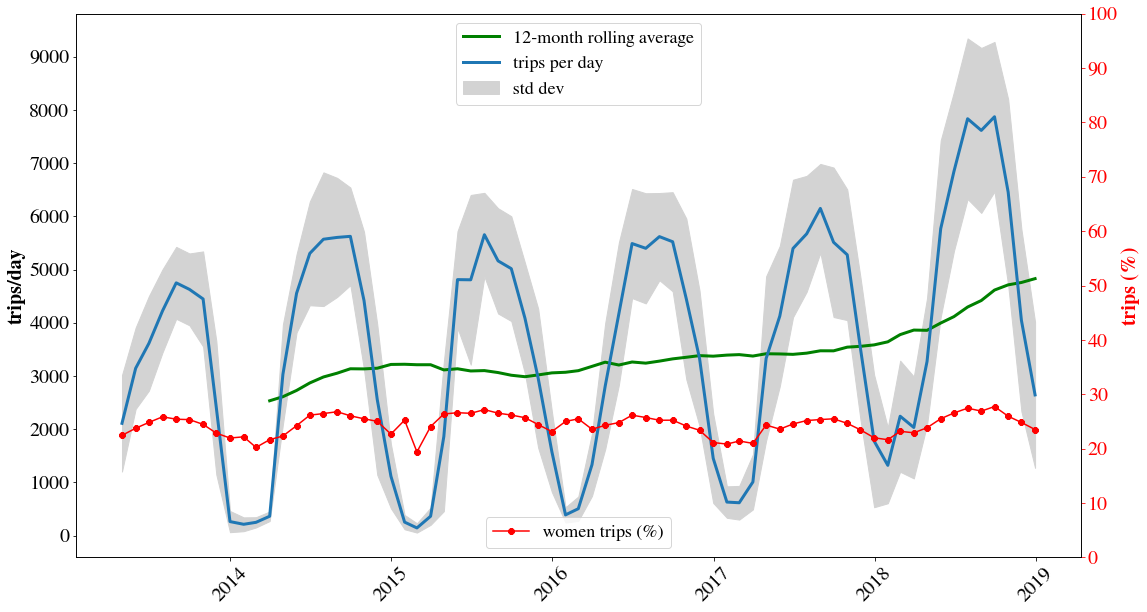

In [44]:
dateFmt = mdate.DateFormatter('%Y')
ax_day_avg_gender_2013 = plt.axes()
ax_day_avg_gender_2013.set_axisbelow(True)
ax_day_avg_gender_2013.xaxis.grid(False)
ax_day_avg_gender_2013.yaxis.grid(False)
#formatter = tkr.FuncFormatter(ch.numbers_in_thousands)
ax_day_avg_gender_2013.plot(trips_12_month_rolling_2013['mean'],label='12-month rolling average',linewidth=3,color='green')
ax_day_avg_gender_2013.plot(trips_per_day_2013['mean'],label='trips per day',linewidth=3)
ax_day_avg_gender_2013.figure.set_size_inches(18,10)
ax_day_avg_gender_2013.xaxis.set_major_formatter(dateFmt)
plt.ylabel('trips/day')
plt.xticks(rotation=45)
plt.yticks(np.arange(0,10001,step=1000))
plt.fill_between(trips_per_day_2013.index,trips_per_day_2013['mean']-trips_per_day_2013['std'],
                 trips_per_day_2013['mean']+trips_per_day_2013['std'],color='lightgray',label='std dev')
plt.legend(loc='center left')
ax_perc_women_2013 = ax_day_avg_gender_2013.twinx()
ax_perc_women_2013.plot(women_percentage_per_month_2013.index,women_percentage_per_month_2013['percentage'],
                          label='women trips (%)',color='red',marker='8')
ax_perc_women_2013.set_ylabel('trips (%)', color='red')
ax_perc_women_2013.yaxis.grid(False)
ax_perc_women_2013.xaxis.set_major_formatter(dateFmt)
ax_perc_women_2013.set_yticks(np.arange(0,30.1,step=5))
ax_perc_women_2013.legend(loc='upper left')
ax_perc_women_2013.tick_params('y',colors='red')

plt.savefig('charts/Trips-Evolution-2013-2018.pdf', format='pdf', dpi=200)
plt.draw()

## Figure: Trips per month and gender - day usage average, standard deviation, and 12-month rolling from 2014 to 2018

### Getting the daily average per month

In [35]:
trips_per_day_2014 = trips_per_day[(trips_per_day.index.year >= 2014)]
#trips_per_day_2014.head()
len(trips_per_day_2014)

60

### Bike use ratio between men and women

In [36]:
women_percentage_per_month_2014 = women_percentage_per_month[(women_percentage_per_month.index.year >= 2014)]
#women_percentage_per_month_2014.head()
len(women_percentage_per_month_2014)

60

### Calculating 12-month rolling average

In [37]:
trips_12_month_rolling_2014 = trips_per_day_2014.sort_index().rolling(12).mean().dropna()
trips_12_month_rolling_2014.head(5)

mean     std
dateindex                  
2014-12-31 3216.625 797.567
2015-01-31 3220.020 797.951
2015-02-28 3211.249 797.235
2015-03-31 3211.273 803.250
2015-04-30 3113.862 841.947

### Creating the chart

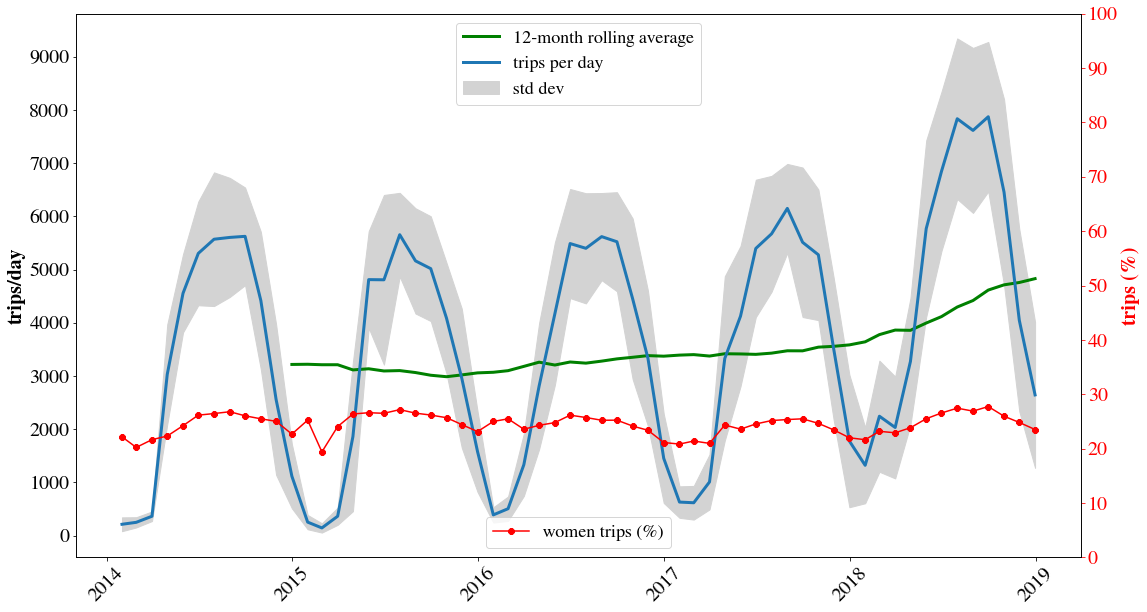

In [45]:
dateFmt = mdate.DateFormatter('%Y')
ax_day_avg_gender_2014 = plt.axes()
ax_day_avg_gender_2014.set_axisbelow(True)
ax_day_avg_gender_2014.xaxis.grid(False)
ax_day_avg_gender_2014.yaxis.grid(False)
#formatter = tkr.FuncFormatter(ch.numbers_in_thousands)
ax_day_avg_gender_2014.plot(trips_12_month_rolling_2014['mean'],label='12-month rolling average',linewidth=3,color='green')
ax_day_avg_gender_2014.plot(trips_per_day_2014['mean'],label='trips per day',linewidth=3)
ax_day_avg_gender_2014.figure.set_size_inches(18,10)
ax_day_avg_gender_2014.xaxis.set_major_formatter(dateFmt)
plt.ylabel('trips/day')
plt.xticks(rotation=45)
plt.yticks(np.arange(0,10001,step=1000))
plt.fill_between(trips_per_day_2014.index,trips_per_day_2014['mean']-trips_per_day_2014['std'],
                 trips_per_day_2014['mean']+trips_per_day_2014['std'],color='lightgray',label='std dev')
plt.legend(loc='center left')
ax_perc_women_2014 = ax_day_avg_gender_2014.twinx()
ax_perc_women_2014.plot(women_percentage_per_month_2014.index,women_percentage_per_month_2014['percentage'],
                          label='women trips (%)',color='red',marker='8')
ax_perc_women_2014.set_ylabel('trips (%)', color='red')
ax_perc_women_2014.yaxis.grid(False)
ax_perc_women_2014.xaxis.set_major_formatter(dateFmt)
ax_perc_women_2014.set_yticks(np.arange(0,30.1,step=5))
ax_perc_women_2014.legend(loc='upper left')
ax_perc_women_2014.tick_params('y',colors='red')

plt.savefig('charts/Trips-Evolution-2014-2018.pdf', format='pdf', dpi=200)
plt.draw()

## Figure: Trips per month and gender - day usage average, standard deviation, and 12-month rolling from 2015 to 2018

### Getting the daily average per month

In [40]:
trips_per_day_2015 = trips_per_day[(trips_per_day.index.year >= 2015)]
#trips_per_day_2015.head()
len(trips_per_day_2015)

48

### Bike use ratio between men and women

In [41]:
women_percentage_per_month_2015 = women_percentage_per_month[(women_percentage_per_month.index.year >= 2015)]
#women_percentage_per_month_2015.head()
len(women_percentage_per_month_2015)

48

### Calculating 12-month rolling average

In [42]:
trips_12_month_rolling_2015 = trips_per_day_2015.sort_index().rolling(12).mean().dropna()
trips_12_month_rolling_2015.head(5)

mean     std
dateindex                  
2015-12-31 3058.150 846.751
2016-01-31 3069.481 847.488
2016-02-29 3099.594 859.282
2016-03-31 3180.258 894.665
2016-04-30 3259.200 876.491

### Creating the chart

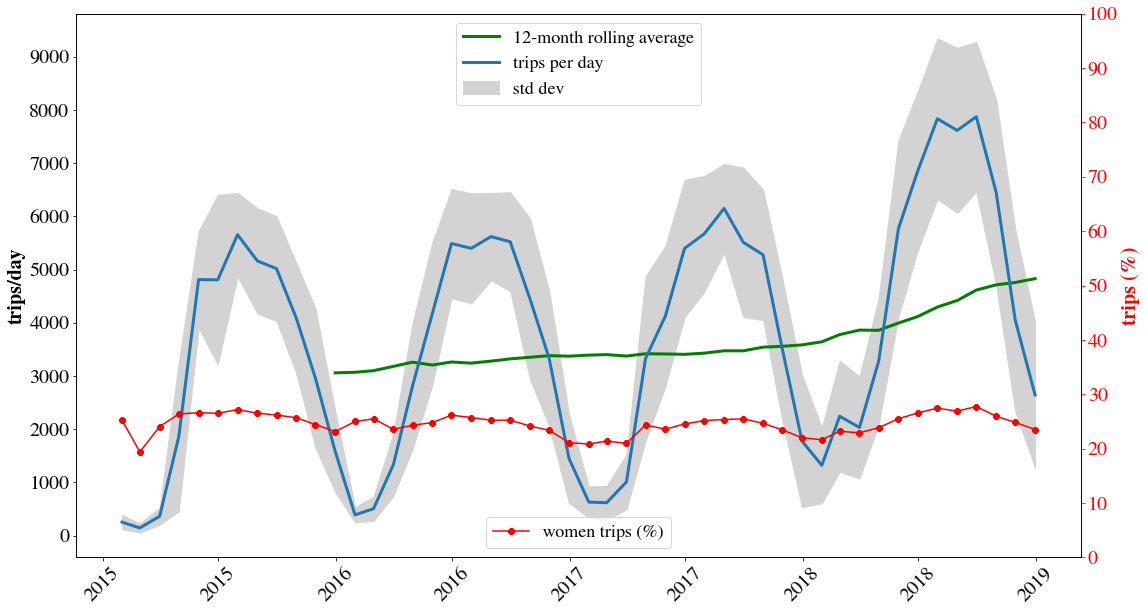

In [46]:
dateFmt = mdate.DateFormatter('%Y')
ax_day_avg_gender_2015 = plt.axes()
ax_day_avg_gender_2015.set_axisbelow(True)
ax_day_avg_gender_2015.xaxis.grid(False)
ax_day_avg_gender_2015.yaxis.grid(False)
#formatter = tkr.FuncFormatter(ch.numbers_in_thousands)
ax_day_avg_gender_2015.plot(trips_12_month_rolling_2015['mean'],label='12-month rolling average',linewidth=3,color='green')
ax_day_avg_gender_2015.plot(trips_per_day_2015['mean'],label='trips per day',linewidth=3)
ax_day_avg_gender_2015.figure.set_size_inches(18,10)
ax_day_avg_gender_2015.xaxis.set_major_formatter(dateFmt)
plt.ylabel('trips/day')
plt.xticks(rotation=45)
plt.yticks(np.arange(0,10001,step=1000))
plt.fill_between(trips_per_day_2015.index,trips_per_day_2015['mean']-trips_per_day_2015['std'],
                 trips_per_day_2015['mean']+trips_per_day_2015['std'],color='lightgray',label='std dev')
plt.legend(loc='center left')
ax_perc_women_2015 = ax_day_avg_gender_2015.twinx()
ax_perc_women_2015.plot(women_percentage_per_month_2015.index,women_percentage_per_month_2015['percentage'],
                          label='women trips (%)',color='red',marker='8')
ax_perc_women_2015.set_ylabel('trips (%)', color='red')
ax_perc_women_2015.yaxis.grid(False)
ax_perc_women_2015.xaxis.set_major_formatter(dateFmt)
ax_perc_women_2015.set_yticks(np.arange(0,30.1,step=5))
ax_perc_women_2015.legend(loc='upper left')
ax_perc_women_2015.tick_params('y',colors='red')

plt.savefig('charts/Trips-Evolution-2015-2018.pdf', format='pdf', dpi=200)
plt.draw()

## Beware of dangerous cyclists
### There're are a lot of them in the 25-30 age range; but, in fact they might occur in all ages.

In [58]:
speedys = t[t.speed >25]
speedys.head()

tripduration               starttime                stoptime  \
126074           132 2018-06-20 06:56:24.766 2018-06-20 06:58:37.250   
26074            126 2017-07-05 19:22:30.000 2017-07-05 19:24:37.000   
161047           130 2018-08-22 19:38:07.787 2018-08-22 19:40:18.652   
51817            132 2018-10-08 13:18:34.285 2018-10-08 13:20:46.431   
87856            114 2018-10-13 15:32:40.488 2018-10-13 15:34:34.872   

        start station id                                 start station name  \
126074                46  Christian Science Plaza - Massachusetts Ave at...   
26074                 46  Christian Science Plaza - Massachusetts Ave at...   
161047                46  Christian Science Plaza - Massachusetts Ave at...   
51817                 46  Christian Science Plaza - Massachusetts Ave at...   
87856                 46  Christian Science Plaza - Massachusetts Ave at...   

        start station latitude  start station longitude  end station id  \
126074                  42.344                  -71.086              52   
26074                   42.344                  -71.086              52   
161047                  42.344                  -71.086              52   
51817                   42.344                  -71.086              52   
87856                   42.344                  -71.086              52   

                 end station name  end station latitude  ...      usertype  \
126074  Newbury St at Hereford St                42.349  ...    Subscriber   
26074   Newbury St at Hereford St                42.349  ...      Customer   
161047  Newbury St at Hereford St                42.349  ...    Subscriber   
51817   Newbury St at Hereford St                42.349  ...    Subscriber   
87856   Newbury St at Hereford St                42.349  ...    Subscriber   

       birth year gender    per_day  hour week_day  weekend  distance  \
126074       1993  1.000 2018-06-20     6        2    False     0.936   
26074          \N  0.000 2017-07-05    19        2    False     0.936   
161047       1994  1.000 2018-08-22    19        2    False     0.936   
51817        1993  1.000 2018-10-08    13        0    False     0.936   
87856        1993  1.000 2018-10-13    15        5     True     0.936   

            month  speed  
126074 2018-06-01 25.527  
26074  2017-07-01 26.743  
161047 2018-08-01 25.920  
51817  2018-10-01 25.527  
87856  2018-10-01 29.558  

[5 rows x 22 columns]

In [ ]:
t["birth year"] = t["birth year"].astype(int)
t["age"] = 2018 - t["birth year"]
speedys = t[t.speed >25].age
normal  = t.age

bins = np.linspace(10, 70, 30)
plt.hist(speedys, bins, alpha=0.5, label='speedys', density=True)
plt.hist(normal, bins, alpha=0.5, label='normal', density=True)
plt.legend(loc='upper right')
plt.show()

## Per-station trip daily pattern

In [53]:
start_stations = trips[['start station id', 'start station name', 'start station latitude', 'start station longitude']]
start_stations.columns = ['id', 'sname', 'lat', 'lon']

end_stations = trips[['end station id', 'end station name', 'end station latitude', 'end station longitude']]
end_stations.columns = ['id', 'sname', 'lat', 'lon']

stations = pd.concat([start_stations, end_stations])

stations.drop_duplicates(subset='id', inplace=True)
stations.set_index('id', inplace=True)
stations.sort_index(inplace=True)
                    
stations['sname'] = stations['sname'].str.replace("'", "&#8217;")
stations['geometry'] = stations.apply(lambda row: Point(row['lon'], row['lat']), axis=1)
stations = gpd.GeoDataFrame(stations, crs={'init': 'epsg:4326'})

print(len(stations), 'stations')

194 stations


In [54]:
@interact(station=widgets.Dropdown(options=stations['sname'].sort_values(), value='MIT at Mass Ave / Amherst St'),
          trip_point=widgets.RadioButtons(options=['start', 'end']))
def trip_daily_pattern(station, trip_point):
    station_id = stations[stations['sname'] == station].index[0]
    day_counts = trips[trips[trip_point + ' station id'] == station_id] \
          [['hour', 'weekend', 'per_day']].drop_duplicates() \
          .groupby(['hour', 'weekend'], as_index=False).agg({'per_day': 'count'})
    trip_counts = trips[trips[trip_point + ' station id'] == station_id] \
                .groupby(['hour', 'weekend'], as_index=False).agg({'tripduration': 'count'})
    counts = day_counts.merge(trip_counts, on=['hour', 'weekend'])
    counts.rename(columns={'per_day': 'day_count', 'tripduration': 'trip_count'}, inplace=True)
    counts['daily_mean'] = counts['trip_count'] / counts['day_count']
    
    plt.figure(figsize=(20, 8))
    width=0.5
        
    for t in [False, True]:
        filtered = counts[counts['weekend'] == t]
        y = filtered['daily_mean']
        x = filtered['hour']
        if len(x) > 0:
            plt.bar(x-width/2 if t else x+width/4, y, width=width, label='weekend' if t else 'working day')
        if len(x) >= 2:  # mininum for spline generation
            spline = CubicSpline(x, y)
            x_vals = np.linspace(x.min(), x.max(), 500, dtype=np.float64)
            y_smooth = spline(x_vals)
            plt.plot(x_vals, y_smooth)
        
    plt.legend()
    plt.show()

interactive(children=(Dropdown(description='station', index=118, options=('175 N Harvard St', '18 Dorrance War…

# Dock-Station Origin-Destination matrix

In [ ]:
pd.crosstab(trips["start station id"], trips["end station id"])

## Individual bike usage

Number of times each bike is used per day:

In [5]:
trips['day'] = trips['per_day'].dt.to_timestamp()
bike_daily_usage = trips.groupby(['bikeid', 'day', 'weekend'], as_index=False).agg({'tripduration': 'count'})
bike_daily_usage.columns = ['bike id', 'day', 'weekend', 'trip count']
bike_daily_usage.head()

bike id        day  weekend  trip count
0        1 2016-10-02     True           4
1        1 2016-10-03    False           2
2        1 2016-10-04    False           8
3        1 2016-10-05    False           4
4        1 2016-10-06    False           2

Per-bike mean daily usage:

Working days


count    4026.0
mean        4.9
std         1.0
min         1.0
25%         4.0
50%         5.1
75%         5.7
max        16.0
Name: trip count, dtype: float64

Weekends


count    4003.0
mean        4.4
std         1.1
min         1.0
25%         3.6
50%         4.3
75%         5.1
max         9.3
Name: trip count, dtype: float64

/usr/local/lib/python3.5/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


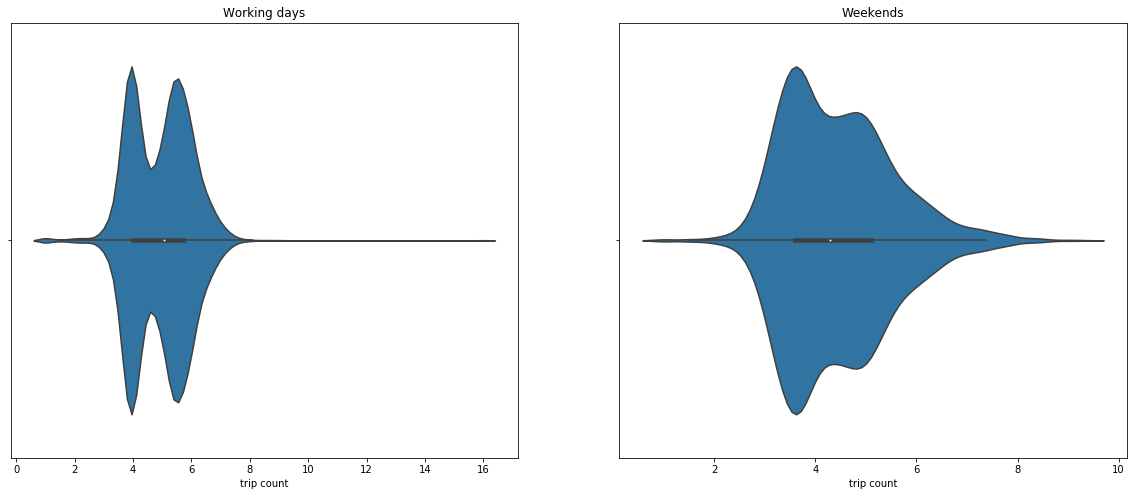

In [6]:
print('Working days')
working_days_bike_mean_daily_usage = \
        bike_daily_usage[~bike_daily_usage['weekend']].groupby('bike id').agg({'trip count': 'mean'})
display(working_days_bike_mean_daily_usage['trip count'].describe())

print('Weekends')
weekends_bike_mean_daily_usage = \
    bike_daily_usage[bike_daily_usage['weekend']].groupby('bike id').agg({'trip count': 'mean'})
display(weekends_bike_mean_daily_usage['trip count'].describe())

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.title('Working days')
sns.violinplot('trip count', data=working_days_bike_mean_daily_usage)
plt.subplot(1, 2, 2)
plt.title('Weekends')
sns.violinplot('trip count', data=weekends_bike_mean_daily_usage)
plt.show()

## Trips by day

Counting trips:

In [7]:
trips_by_day = trips.groupby(['day', 'weekend'], as_index=False).agg({'tripduration': 'count'})
trips_by_day.columns = ['day', 'weekend', 'trip count']
trips_by_day.head()

day  weekend  trip count
0 2016-10-01     True        1526
1 2016-10-02     True        2599
2 2016-10-03    False        5807
3 2016-10-04    False        5918
4 2016-10-05    False        5889

Weekends:

Working days


count     542.0
mean     4509.3
std      2637.9
min        21.0
25%      2175.8
50%      4639.5
75%      6573.8
max      9975.0
Name: trip count, dtype: float64

Weekends


count     218.0
mean     3288.3
std      2283.8
min        63.0
25%      1162.8
50%      3271.5
75%      5068.2
max      8187.0
Name: trip count, dtype: float64

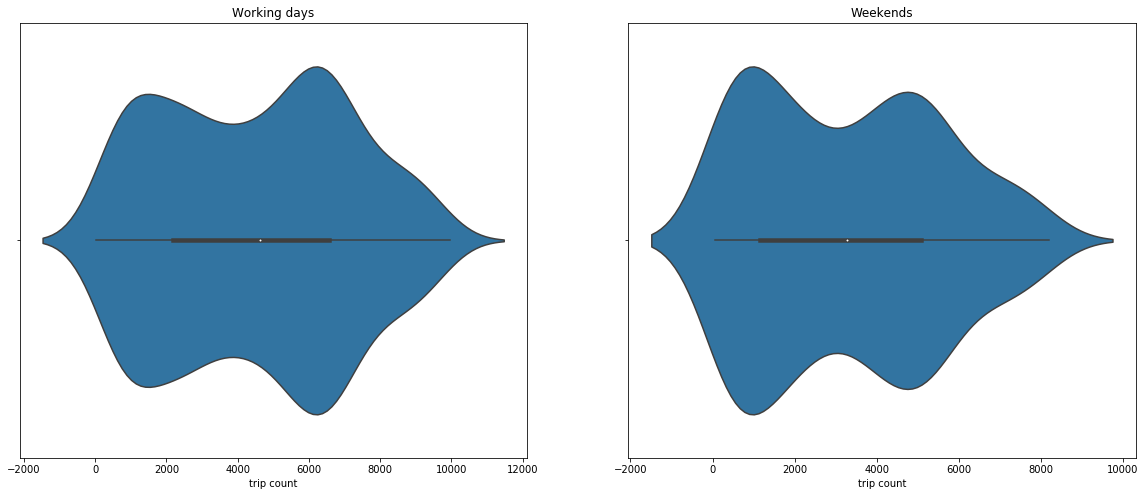

In [8]:
print('Working days')
working_days_mean_daily_usage = trips_by_day[~trips_by_day['weekend']]
display(working_days_mean_daily_usage['trip count'].describe())

print('Weekends')
weekends_mean_daily_usage = trips_by_day[trips_by_day['weekend']]
display(weekends_mean_daily_usage['trip count'].describe())

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.title('Working days')
sns.violinplot('trip count', data=working_days_mean_daily_usage)
plt.subplot(1, 2, 2)
plt.title('Weekends')
sns.violinplot('trip count', data=weekends_mean_daily_usage)
plt.show()

## Trips by day of week

In [9]:
trips_by_weekday = trips.groupby(['day', 'week_day'], as_index=False).agg({'tripduration': 'count'})
trips_by_weekday.columns = ['day', 'weekday', 'trip count']
trips_by_weekday.head()

day  weekday  trip count
0 2016-10-01        5        1526
1 2016-10-02        6        2599
2 2016-10-03        0        5807
3 2016-10-04        1        5918
4 2016-10-05        2        5889

Sunday


count     109.0
mean     3197.9
std      2246.1
min        63.0
25%       968.0
50%      3284.0
75%      4994.0
max      7972.0
Name: trip count, dtype: float64

Monday


count     109.0
mean     4215.0
std      2508.6
min        38.0
25%      2283.0
50%      4164.0
75%      6284.0
max      9377.0
Name: trip count, dtype: float64

Tuesday


count     108.0
mean     4527.4
std      2557.2
min        77.0
25%      2444.0
50%      4863.0
75%      6253.5
max      9862.0
Name: trip count, dtype: float64

Wednesday


count     109.0
mean     4695.8
std      2660.8
min       197.0
25%      2178.0
50%      5010.0
75%      6824.0
max      9603.0
Name: trip count, dtype: float64

Thurday


count     108.0
mean     4631.7
std      2708.8
min        21.0
25%      2143.5
50%      4821.5
75%      6687.2
max      9587.0
Name: trip count, dtype: float64

Fridy


count     108.0
mean     4477.3
std      2768.9
min        65.0
25%      2134.5
50%      4636.5
75%      6648.5
max      9975.0
Name: trip count, dtype: float64

Saturday


count     109.0
mean     3378.7
std      2327.8
min       106.0
25%      1261.0
50%      3259.0
75%      5072.0
max      8187.0
Name: trip count, dtype: float64

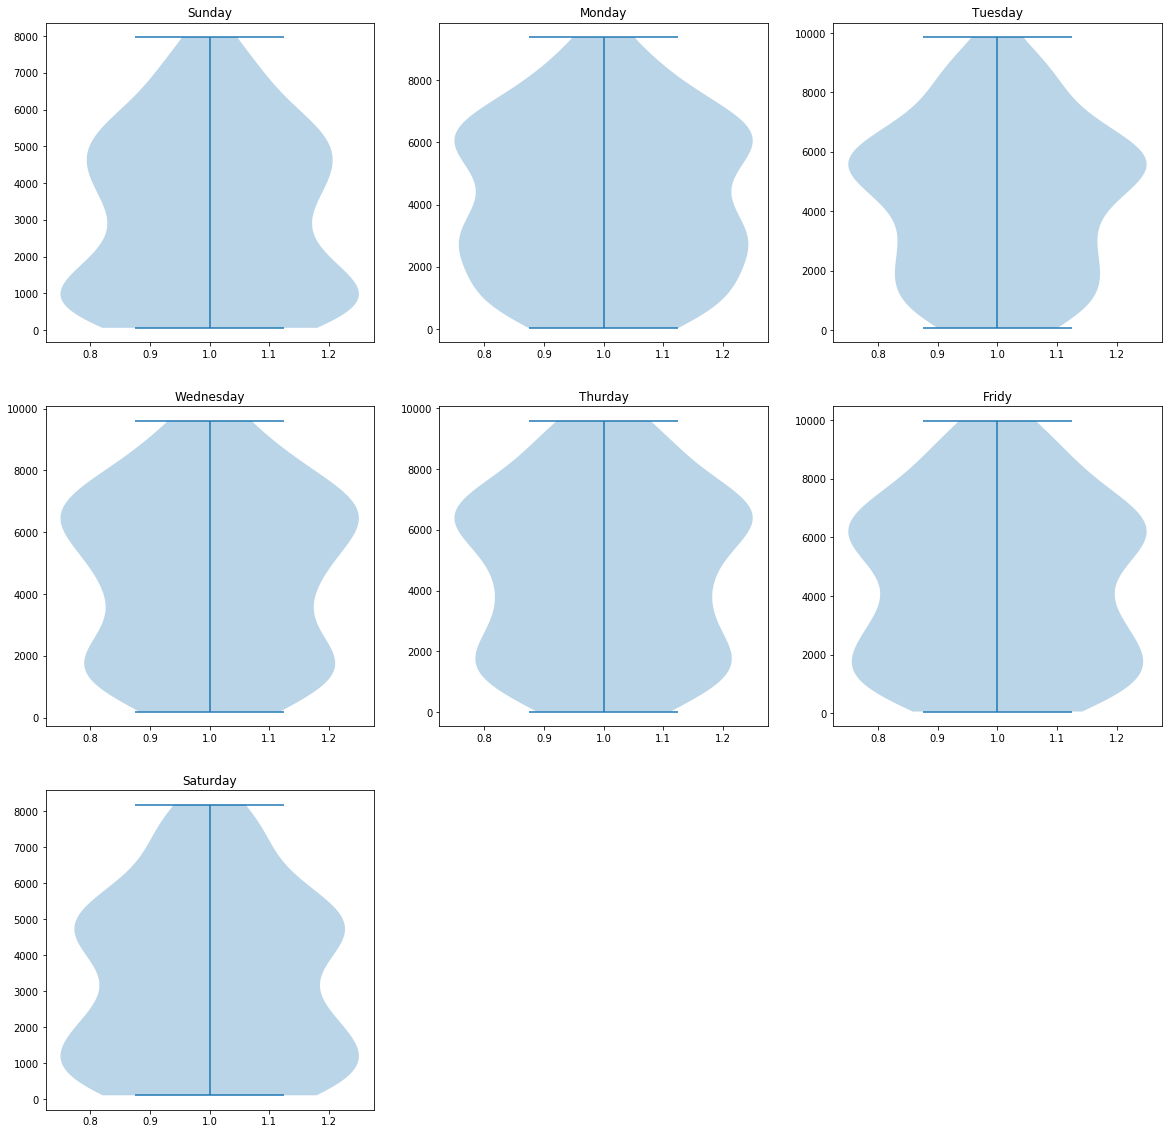

In [10]:
days = [(6, 'Sunday'), (0, 'Monday'), (1, 'Tuesday'), (2, 'Wednesday'), (3, 'Thurday'), (4, 'Fridy'), (5, 'Saturday')]
plt.figure(figsize=(20, 20))
for i in range(len(days)):
    print(days[i][1])
    per_weekday_mean_daily_usage = trips_by_weekday[trips_by_weekday['weekday'] == days[i][0]]
    display(per_weekday_mean_daily_usage['trip count'].describe())
    plt.subplot(3, 3, i+1)
    plt.title(days[i][1])
    plt.violinplot('trip count', data=per_weekday_mean_daily_usage)
plt.show()

## Trips by month

From oct/2017 to sep/2018.

Oct/2017


count      31.0
mean     5277.9
std      1228.1
min      2369.0
25%      4588.5
50%      5570.0
75%      6247.0
max      6683.0
Name: trip count, dtype: float64

Nov/2017


count      30.0
mean     3515.4
std      1337.7
min      1055.0
25%      2337.0
50%      3664.0
75%      4481.0
max      5970.0
Name: trip count, dtype: float64

Dec/2017


count      31.0
mean     1776.5
std      1244.0
min        93.0
25%       447.0
50%      2175.0
75%      2725.0
max      3748.0
Name: trip count, dtype: float64

Jan/2018


count      31.0
mean     1320.4
std       713.2
min        21.0
25%       819.0
50%      1424.0
75%      1906.0
max      2509.0
Name: trip count, dtype: float64

Feb/2018


count      28.0
mean     2243.4
std      1044.5
min       501.0
25%      1471.5
50%      2345.0
75%      2870.2
max      4575.0
Name: trip count, dtype: float64

Mar/2018


count      30.0
mean     2099.5
std       895.3
min       368.0
25%      1424.2
50%      2221.0
75%      2703.5
max      3876.0
Name: trip count, dtype: float64

Apr/2018


count      30.0
mean     3273.1
std      1191.5
min       664.0
25%      2479.8
50%      3292.5
75%      3952.5
max      5637.0
Name: trip count, dtype: float64

May/2018


count      31.0
mean     5769.4
std      1658.2
min      1897.0
25%      5165.0
50%      6203.0
75%      7045.0
max      7565.0
Name: trip count, dtype: float64

Jun/2018


count      30.0
mean     6845.1
std      1495.5
min      2872.0
25%      5863.0
50%      7058.0
75%      7995.0
max      9160.0
Name: trip count, dtype: float64

Jul/2018


count      31.0
mean     7835.1
std      1509.7
min      3466.0
25%      6983.5
50%      7916.0
75%      9178.5
max      9862.0
Name: trip count, dtype: float64

Aug/2018


count      31.0
mean     7615.4
std      1550.8
min      3207.0
25%      7064.5
50%      8182.0
75%      8657.0
max      9427.0
Name: trip count, dtype: float64

Sep/2018


count      30.0
mean     7872.7
std      1405.8
min      4064.0
25%      6975.2
50%      7826.0
75%      9168.8
max      9975.0
Name: trip count, dtype: float64

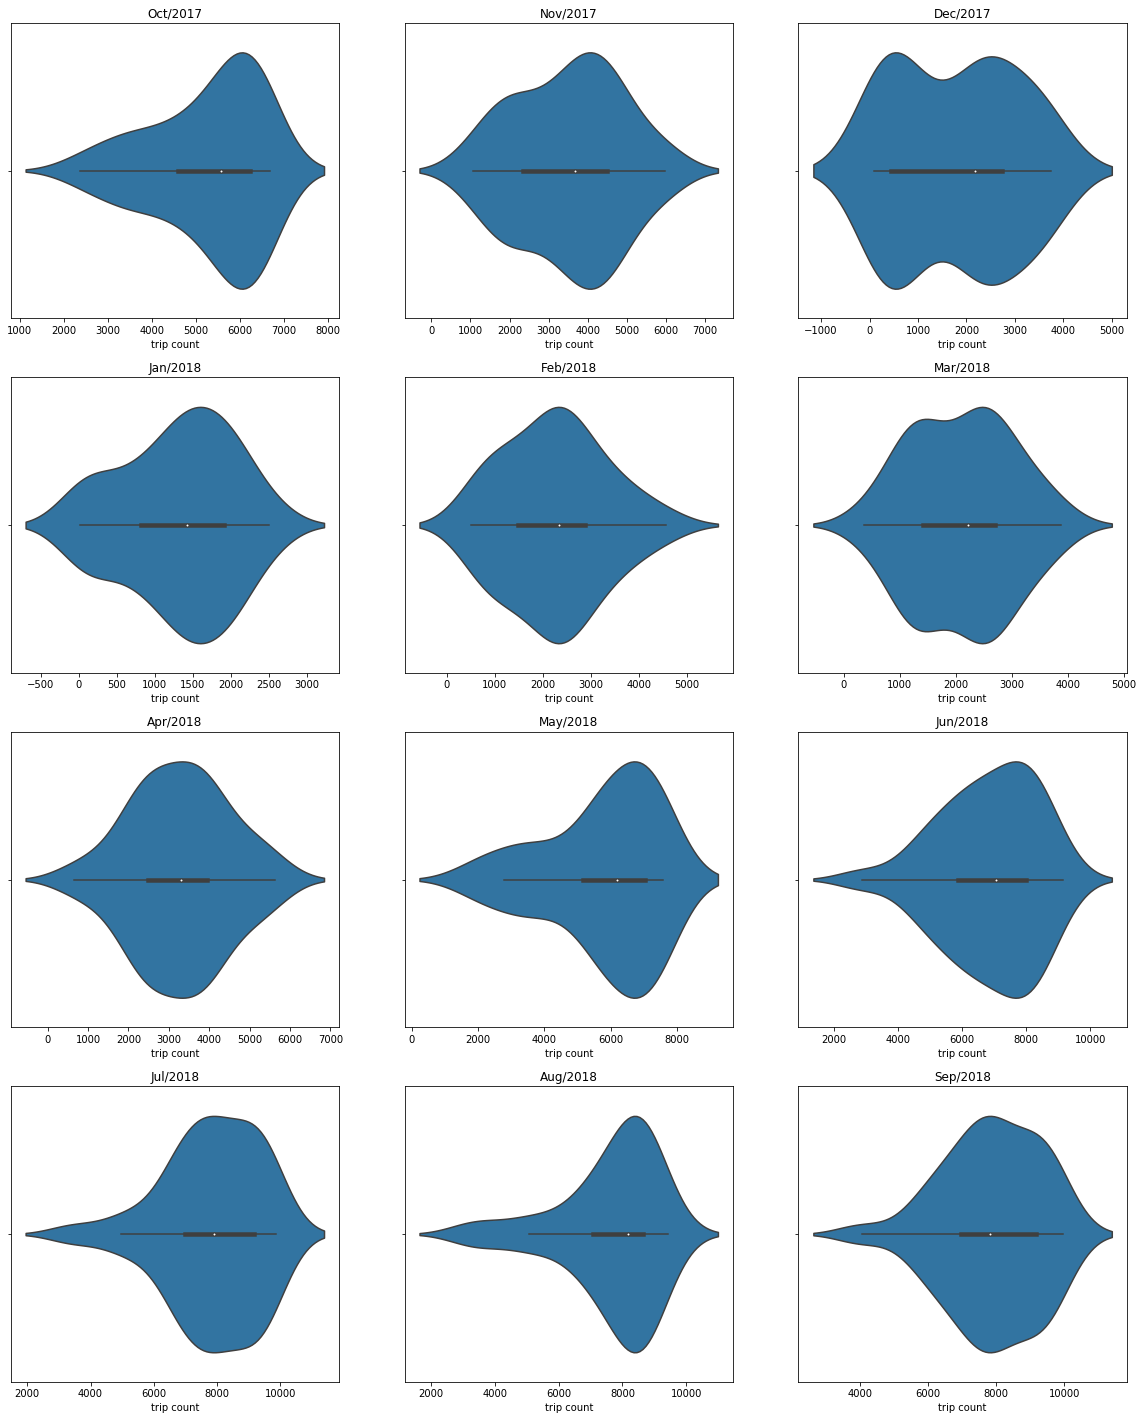

In [11]:
start = pd.Timestamp(day=1, month=10, year=2017)
end = pd.Timestamp(day=1, month=10, year=2018)

trips['month'] = trips['starttime'].dt.to_period('m').dt.to_timestamp()
months = trips['month'].unique()
months.sort()
plt.figure(figsize=(20, 25))
cnt = 1
for i in range(len(months)):
    month = pd.Timestamp(months[i])
    if month < start: continue
    if month >= end: continue
        
    title = month.strftime('%h/%Y')
    print(title)

    month_daily_trips = trips[trips['month'] == month].groupby('day').agg({'tripduration': 'count'})
    month_daily_trips.columns = ['trip count']
    display(month_daily_trips['trip count'].describe())

    plt.subplot(4, 3, cnt)
    sns.violinplot('trip count', data=month_daily_trips)
    plt.title(title)
    cnt += 1
plt.show()